# Lab Three: Extended Logistic Regression

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Preparation and Overview](#prep)<br>
  1.1 [Business Case](#business_case)<br>
  1.2 [Define Class Variables](#class_variables)<br>
  1.3 [Training and Testing Data](#split)<br>
 2. [Modeling](#modeling)<br>
  2.1 [One-Verses-All Logistic Regression](#1vall)<br>
  2.2 [Train the Model](#train)<br>
  2.3 [Compare to Scikit-Learn](#compare)<br>
 3. [Deployment](#deployment)<br>
  3.1 [Advice](#advice)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  4.2 [Mean Square Error](#mse)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="prep"></a>
## Preparation and Overview


<a id="business_case"></a>
### Business Case

>__[20 points]__ Explain the tast and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis?

For this project we will return to the diabetes dataset we used for Lab1. Briefly, this dataset contains information regarding diabetic patients who were admitted to the hospital.

This dataset contains labels that characterize whether the patient was readmitted to the hospital in less than 30 days, readmitted to the hospital after more than 30 days, or not readmitted at all. Predicting these labels will be our classification task. 

There are two potential sets of parties interested in these results. 

- First, emergency medical care centers. These care centers will likely be interested in the results because of the insight they may provide for the day to day operations of the centers. We may discover that certain types of patients are much more likely to be readmitted to an emergency medical care center. This information could be used by the care centers to provide extra attention to the most at-risk patients once identified. In this case, the model would likely be deployed so that the healthcare professionals can have feedback as soon as possible. Throughout this project, we will focus on this possibility so as not to split our time and energy.

- Second, special focus groups, such as the [American Diabetes Association](http://www.diabetes.org/). These organizations can use the insight gained from our studies to issue standards or suggestions. These standards or suggestions could then be implemented at individual care centers. Since the ADA is a large organization with a relative large sphere of influence, these suggestions could help ensure parity accross a variety of care centers. In this case, the model would mostly be used for offline analysis. For this project, we will not focus on this possibility.

<a id="class_variables"></a>
### Define Class Variables

> __[5 points]__ (_mostly the same processes as from previous labs_) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Descrive the final dataset that is used for classificiation/regression (include a description of any newly formed variables you created).

In [1]:
# load the full dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

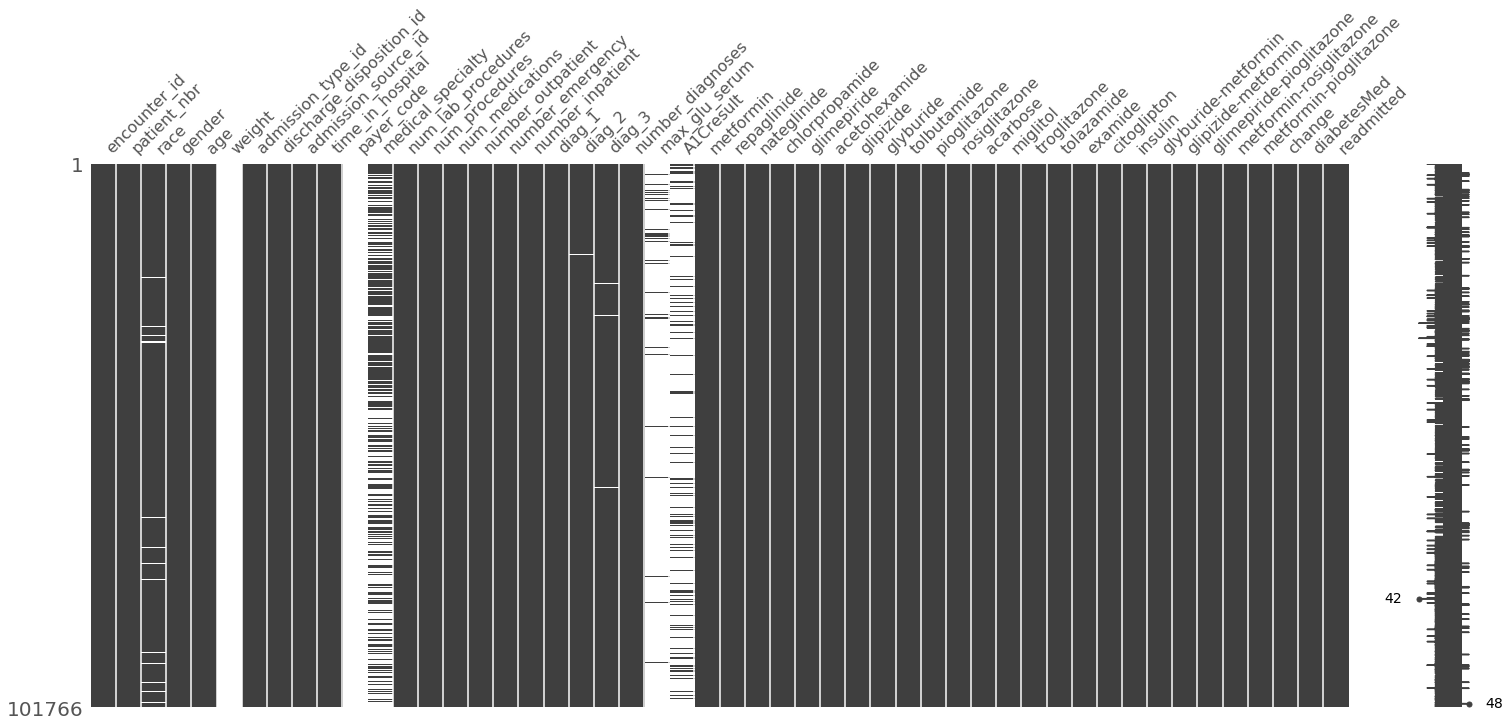

In [2]:
# now convert columns that should be numeric to numeric types,
# then drop the columns missing too much data and then the rows with any missing data. 

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

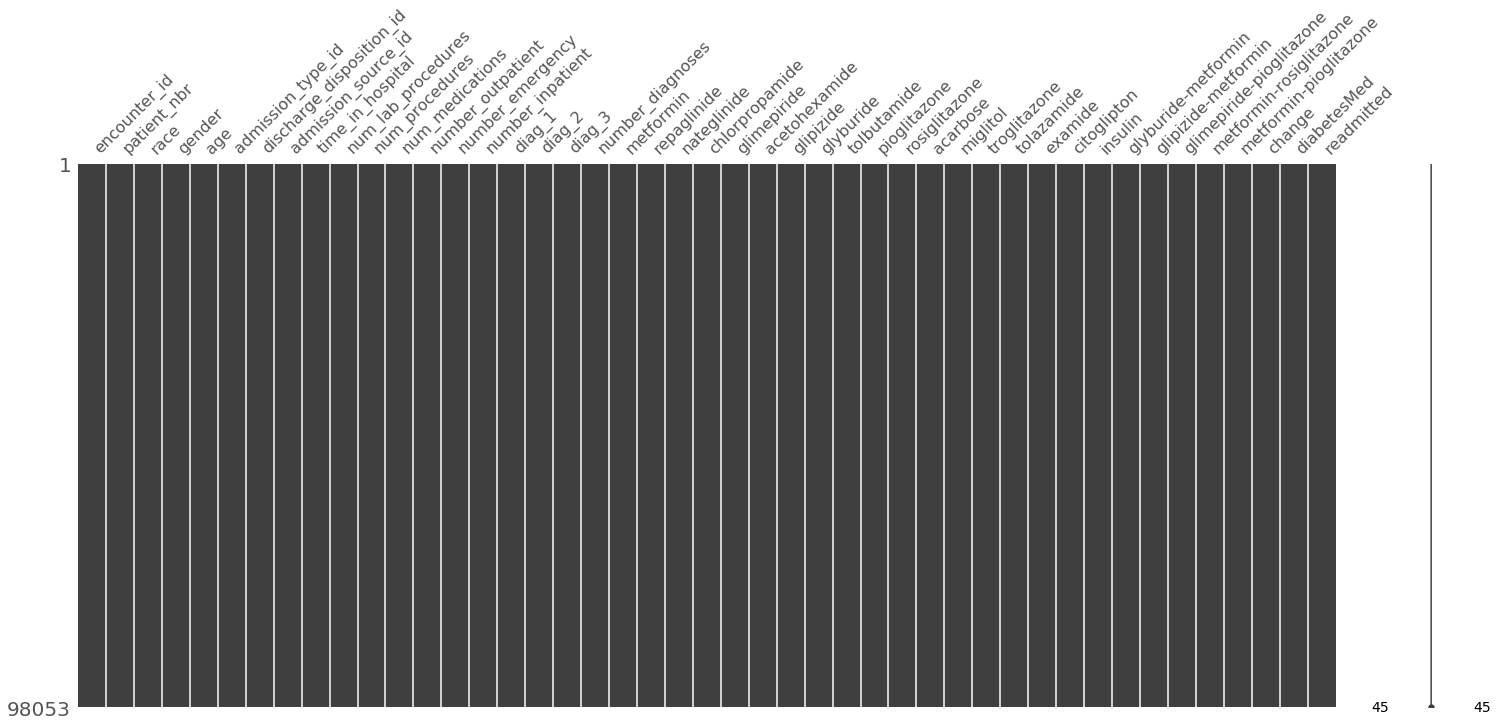

In [3]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

In [4]:
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category')
        df = pd.concat([df, dfDummies], axis=1)
    return df

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)

In [5]:
# these are the columns that use the ICD9 data

explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)

In [6]:
# these are the columns that need one hot encoded

one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']

for col in one_hot_encode_list:
    full_df = one_hot_encode(full_df, col)

full_df.drop(one_hot_encode_list+explain_list, axis=1, inplace=True)

In [7]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study

full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [8]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id

drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [9]:
# now label encoding
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})
full_df['gender'] = full_df['gender'].replace({'Male':0,'Female':1,'Unknown/Invalid':None})
full_df['change'] = full_df['change'].replace({'Ch':0,'No':1})
full_df['diabetesMed'] = full_df['diabetesMed'].replace({'Yes':0,'No':1})

In [10]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [11]:
# normalize the columns so that the response is not dominated by a few columns with large values

def normalize_column(col):
    if np.abs(full_df[col].max()-1) > 0.01 or np.abs(full_df[col].min()) > 0.01 :
        print('normalizeing : ',col)
        min_val = full_df[col].min()
        max_val = full_df[col].max()
        interval = max_val - min_val
        full_df[col] = full_df[col].apply(lambda x: (x-min_val)/interval)
        
cols = list(full_df)
cols.remove('readmitted')
for col in cols:
    normalize_column(col)

normalizeing :  age
normalizeing :  time_in_hospital
normalizeing :  num_lab_procedures
normalizeing :  num_procedures
normalizeing :  num_medications
normalizeing :  number_outpatient
normalizeing :  number_emergency
normalizeing :  number_inpatient
normalizeing :  number_diagnoses
normalizeing :  freq


In [12]:
# now save the csv so we don't have to rerun these cells each time
full_df.to_csv('data/processed_data.csv',index=False)

<a id="split"></a>
### Training and Testing Data

>__[5 points]__ Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. __Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?__

In [13]:
from sklearn.model_selection import train_test_split

# split the data and the target
data_cols = list(full_df)
data_cols.remove('readmitted')
data = full_df[data_cols]
target = full_df['readmitted']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2)

As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. 

Moreover, since we are using logistic regression which only splits the full parameter space using a single hyper-plane, we may not even need the full parameter space to be populated. It is acceptable for the space to be sufficiently populated for the model to find the appropriate hyper-plane.

In our case we have around 100,000 instances in our data in the set and we only have around 75 featrues (parameters to train), we could use a smaller training set and still have good accuracy. In some parts of this project we used as small as 10% of the data for training to reduce training time. 

<a id="modeling"></a>
## Modeling

> The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

In [14]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy.special import expit
from scipy.optimize import minimize_scalar

import copy

from numpy.linalg import pinv
from sklearn.datasets import load_iris
from scipy.optimize import fmin_bfgs

import multiprocessing as mp

In [15]:
y = (target_train == 'NO').astype(np.int).values # make problem binary

y_test = (target_test == 'NO').astype(np.int).values # make problem binary

In [16]:
%%time
class BinaryLogisticRegression:
    '''
    method: 'default', 'LineSearchLogisticRegression', 'StochasticLogisticRegression', 
    'MiniBatchStochasticLogisticRegression','HessianBinaryLogisticRegression', 'BFGSBinaryLogisticRegression'
    regularization_metric: 'NA', 'L1', 'L2'
    batch_size: float between 0 to 1, only valid when call 'MiniBatchStochasticLogisticRegression' method
    '''
    def __init__(self, eta, iterations=20, C=0.001, method='default', regularization_metric='NA',batch_size=0.1):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.method = method
        self.regularization_metric = regularization_metric
        self.batch_size = batch_size
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    def objective_function(self,w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    def _get_l1_dev(self,val):
        if val > 0:
            return 1
        elif val == 0:
            return 0
        else:
            return -1

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    def _get_l1_dev(self,x):
        if x>0:
            return 1
        elif x == 0:
            return 0
        else:
            return -1

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization_metric == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization_metric == 'L1':
            tmp = self.w_[1:].copy()
            gradient[1:] += -np.vectorize(self._get_l1_dev)(tmp) * self.C

        return gradient
    
    def _get_gradient_StochasticLogisticRegression(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False)# get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization_metric == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization_metric == 'L1':
            tmp = self.w_[1:].copy()
            gradient[1:] += -np.vectorize(self._get_l1_dev)(tmp) * self.C
        
        return gradient

    def _get_gradient_MiniBatchStochasticLogisticRegression(self,X,y):
        Idx = np.arange(len(y))
        np.random.shuffle(Idx)
        sample_nbr = int(len(y)*self.batch_size)
        X, y = X[Idx[:sample_nbr]], y[Idx[:sample_nbr]]
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization_metric == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization_metric == 'L1':
            tmp = self.w_[1:].copy()
            gradient[1:] += -np.vectorize(self._get_l1_dev)(tmp) * self.C

        return gradient

    def _get_gradient_HessianBinaryLogisticRegression(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization_metric == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif self.regularization_metric == 'L1':
            tmp = self.w_[1:].copy()
            gradient[1:] += -np.vectorize(self._get_l1_dev)(tmp) * self.C
        
        return pinv(hessian) @ gradient
        
    def line_search_function(self,eta,X,y,w,grad,C):
        wnew = w + grad*eta
        yhat = (1/(1+np.exp(-X @ wnew))) >0.5
        return np.mean((y-yhat)**2)-C*np.mean(wnew**2)
    
    def objective_gradient(self,w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if self.regularization_metric == 'L2':
            gradient[1:] += -2 * w[1:] * self.C
        elif self.regularization_metric == 'L1':
            tmp = w[1:].copy()
            gradient[1:] += -np.vectorize(self._get_l1_dev)(tmp) * self.C

        return -gradient
 
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
        
    def fit(self, X, y):
        if self.method == 'default':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb,y)
                self.w_ += gradient*self.eta # multiply by learning rate 
                
        elif self.method == 'LineSearchLogisticRegression':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb,y)

                # do line search in gradient direction, using scipy function
                opts = {'maxiter':self.iters/20} # unclear exactly what this should be
                res = minimize_scalar(self.line_search_function, # objective function to optimize
                                      bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                      args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                      method='bounded', # bounded optimization for speed
                                      options=opts) # set max iterations

                eta = res.x # get optimal learning rate
                self.w_ += gradient*eta # set new function values
                
        elif self.method == 'StochasticLogisticRegression':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient_StochasticLogisticRegression(Xb,y)
                self.w_ += gradient*self.eta # multiply by learning rate 
        
        elif self.method == 'MiniBatchStochasticLogisticRegression':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape
            
            self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient_MiniBatchStochasticLogisticRegression(Xb,y)
                self.w_ += gradient*self.eta # multiply by learning rate 

        elif self.method == 'HessianBinaryLogisticRegression':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
            gradient = self._get_gradient_HessianBinaryLogisticRegression(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
        
        elif self.method == 'BFGSBinaryLogisticRegression':
            Xb = self._add_bias(X) # add bias term
            num_samples, num_features = Xb.shape

            self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                                np.zeros((num_features,1)), # starting point
                                fprime=self.objective_gradient, # gradient function
                                args=(Xb,y,self.C), # extra args for gradient and objective function
                                gtol=1e-03, # stopping criteria for gradient, |v_k|
                                maxiter=self.iters, # stopping criteria iterations
                                disp=False)

            self.w_ = self.w_.reshape((num_features,1))

CPU times: user 1.78 ms, sys: 118 µs, total: 1.9 ms
Wall time: 93.7 µs
Parser   : 139 ms


In [17]:
%%time
blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001,
                               method='BFGSBinaryLogisticRegression',
                               regularization_metric='L1',
                               batch_size=0.2)

blr.fit(data_train,y)
yhat = blr.predict(data_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
print('f1 score is ',f1_score(y_test,yhat))

Accuracy of:  0.7134771301820407
f1 score is  0.7607001405391594
CPU times: user 4min 35s, sys: 20.5 s, total: 4min 56s
Wall time: 10.6 s


<a id="1vall"></a>
### One-Verses-All Logistic Regression

> __[20 points]__ Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
- Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. 
- Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.

In [18]:
class MultiClassLogisticRegression:
    '''
    method: 'default', 'LineSearchLogisticRegression', 'StochasticLogisticRegression', 
    'MiniBatchStochasticLogisticRegression','HessianBinaryLogisticRegression', 'BFGSBinaryLogisticRegression'
    regularization_metric: 'NA', 'L1', 'L2'
    batch_size: float between 0 to 1, only valid when call 'MiniBatchStochasticLogisticRegression' method
    processes: number of multiprocesses to use, default value 1
    fit function: instead of fit, use multi_fit, multi_predict_proba, multi_predict
    '''
    def __init__(self, eta, iterations=20, C=0.0001, method='default', 
                 regularization_metric='NA',batch_size=0.1,processes=1):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.method = method
        self.regularization_metric = regularization_metric
        self.batch_size = batch_size
        self.processes = processes


        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def bi_fit(self,train_set):
        X,y = train_set[0], train_set[1]
        blr = BinaryLogisticRegression(self.eta,self.iters,self.C,
                                           method=self.method,
                                           regularization_metric=self.regularization_metric,
                                           batch_size=self.batch_size)
        blr.fit(X,y)
        return blr

    def multi_fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        train_sets = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval).astype(np.int)  # create a binary problem
            train_sets.append([X,y_binary])
        pool = mp.Pool(processes=self.processes)
        self.classifiers_ = pool.map(self.bi_fit, train_sets)
        pool.close()
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def bi_proba(self,predict_set):
        blr, X = predict_set[0], predict_set[1]
        return blr.predict_proba(X).reshape((len(X),1))

    def multi_predict_proba(self,X):
        predict_sets = [[blr,X] for blr in self.classifiers_]
        pool = mp.Pool(processes=self.processes)
        probs = pool.map(self.bi_proba, predict_sets)
        pool.close()
        return np.hstack(probs) # make into single matrix
    
    def multi_predict(self,X):
        return np.argmax(self.multi_predict_proba(X),axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler

ds = load_iris()
X = ds.data

X = StandardScaler().fit(X).transform(X)
y_not_binary = ds.target # note problem is NOT binary anymore, there are three classes!

target_test_encode = target_test.replace({'NO':0,'<30':1,'>30':2})
target_train_encode = target_train.replace({'NO':0,'<30':1,'>30':2})

When we implemented the one-verses-all technique we used multiprocessing. In this method each binary classifier is trained and predicted on a separate thread. 

### Train the Model
<a id="train"></a>

> __[15 points]__ Train your classifier to achieve good generalization performance. That is, adjust the __optimization technique__ and the value of the __regularization term "C"__ to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

In [27]:
method_list= ['default', 'LineSearchLogisticRegression','StochasticLogisticRegression', 
    'MiniBatchStochasticLogisticRegression','HessianBinaryLogisticRegression', 'BFGSBinaryLogisticRegression']
regularization_metric_list = ['NA', 'L1', 'L2', 'L1L2']

In [ ]:
accuracy_dict = {}
def accu(method,regularization_metric,C,X,y_mul,X_test,y_test_mul):
    lr = MultiClassLogisticRegression(eta=0.1,iterations=500,C=C,
                                           method=method,
                                           regularization_metric=regularization_metric,
                                          batch_size=0.2,processes=2)
    lr.multi_fit(X,y_mul)
    yhat = lr.multi_predict(X_test)
    return accuracy_score(y_test_mul,yhat)
for method in method_list:
    for regularization_metric in regularization_metric_list:
        tmpDict = {}
        C_l = 0
        C_r = 1
        curDist = 2
        while C_r - C_l > 0.001 and curDist/abs(C_r-C_l) > 1.5:
            curDist = C_r-C_l
            C_checks = np.arange(C_l, C_r+curDist/4, curDist/4)
            C_accus = []
            for C in C_checks:
                if C not in tmpDict:
                    tmpDict[C] = accu(method,regularization_metric,C,X,y_mul,X_test,y_test_mul)
                C_accus += [[C,tmpDict[C]]]
            C_accus = sorted(C_accus,key=lambda l:l[1], reverse=True)
            C_l,C_r = C_accus[0][0], C_accus[1][0]
            C_l,C_r = min(C_l,C_r), max(C_l,C_r)
        accuracy_dict[method+' '+regularization_metric] = tmpDict
        print(method+' '+regularization_metric,max(accuracy_dict[method+regularization_metric].values()))
import json
with open('data.json', 'w') as outfile:
    json.dump(accuracy_dict, outfile)

Here to optimize the C value for each combination of method and regulization metric, we start with left bound 0 and right bound 1. Choose 5 sample points from interval $[0,1]$ uniformly, evalate the accuracy corresponding to each C value. Update the left bound and right bound to the C values with highest accuracies. Repeat the procedure until the difference of the left bound and right bound is less than 0.001 or the boundary value is not updating. Then select the highest accuracy from all accuracies. (Most procedures evaluates 17 C's, except the early stopping ones.)
Also since the data size is quite large, and linear searching method is taking significantly long time, we exclude this method.

_note_ we ran the above code to generate the json file on a different machine (m2 as a standalone python script) and then copied the generated json file to the physics server where the rest of this notebook was run.

In [28]:
import json
with open('Jings_Lab3/data.json', 'r') as f:
    accu_Dict = json.load(f)

In [29]:
new_accu_Dict = {}
for param in accu_Dict:
    new_accu_Dict[param] = [[float(key),accu_Dict[param][key]] for key in accu_Dict[param]]
    new_accu_Dict[param] = sorted(new_accu_Dict[param],key=lambda l:l[0], reverse=False)

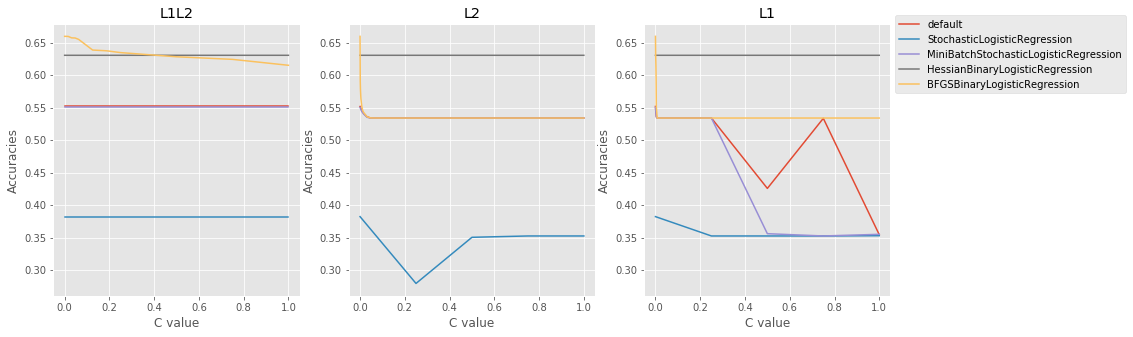

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,3,1)
for param in new_accu_Dict:
    if param[-3:] == '1L2':
        ax.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax.set_xlabel('C value')
ax.set_ylabel('Accuracies')
ax.set_title('L1L2')

ax1 = fig.add_subplot(1,3,2,sharey = ax)
for param in new_accu_Dict:
    if param[-3:] == ' L2':
        ax1.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax1.set_xlabel('C value')
ax1.set_ylabel('Accuracies')
ax1.set_title('L2')

ax2 = fig.add_subplot(1,3,3,sharey = ax)
for param in new_accu_Dict:
    if param[-3:] == ' L1':
        ax2.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]],label=param.split()[0])
ax2.set_xlabel('C value')
ax2.set_ylabel('Accuracies')
ax2.set_title('L1')
l = plt.legend(bbox_to_anchor=(1, 1.05))

Here we can see that the BFGS and Hessian method have high accuracy given same C value, this may be because they take less steps to reach the optimize point of the parameters than other method. Also MiniBatch method and other methods are much better than Stochastic method, which is not suprising since the actual train set size of Stochastic method is same as the step number (500, significantly less than the train set size ~ 100,000).

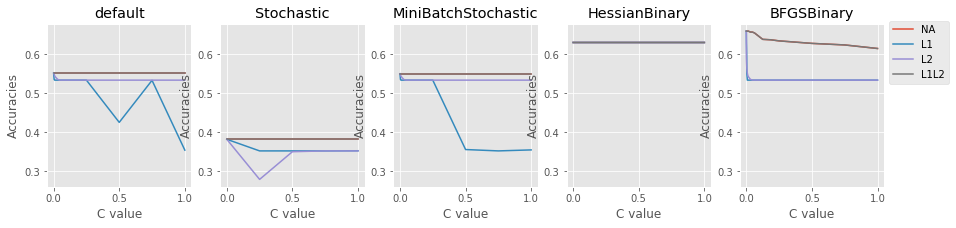

In [31]:
fig = plt.figure(figsize = (15,3))
ax = fig.add_subplot(1,5,1)
for param in new_accu_Dict:
    if param[0] == 'd':
        ax.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax.set_xlabel('C value')
ax.set_ylabel('Accuracies')
ax.set_title('default')

ax1 = fig.add_subplot(1,5,2,sharey = ax)
for param in new_accu_Dict:
    if param[0] == 'S':
        ax1.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax1.set_xlabel('C value')
ax1.set_ylabel('Accuracies')
ax1.set_title('Stochastic')


ax2 = fig.add_subplot(1,5,3,sharey = ax)
for param in new_accu_Dict:
    if param[0] == 'M':
        ax2.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax2.set_xlabel('C value')
ax2.set_ylabel('Accuracies')
ax2.set_title('MiniBatchStochastic')

ax3 = fig.add_subplot(1,5,4,sharey = ax)
for param in new_accu_Dict:
    if param[0] == 'H':
        ax3.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]])
ax3.set_xlabel('C value')
ax3.set_ylabel('Accuracies')
ax3.set_title('HessianBinary')

ax4 = fig.add_subplot(1,5,5,sharey = ax)
for param in new_accu_Dict:
    if param[0] == 'B':
        ax4.plot([pair[0] for pair in new_accu_Dict[param]], [pair[1] for pair in new_accu_Dict[param]],label=param.split()[1])
ax4.set_xlabel('C value')
ax4.set_ylabel('Accuracies')
ax4.set_title('BFGSBinary')
l = plt.legend(bbox_to_anchor=(1, 1.05))

From the plots above, we can see that for all methods and metrics, when C values is 0, the accuracy is highest. This is because that the data set size is ~ 100,000 and the parameters to train is 77, the parameters are unlikely to be overfitted. Thus we can remove the regulization term.

<a id="compare"></a>
### Compare to Scikit-Learn

> __[15 points]__ Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. __Discuss the results.__

In [20]:
%%timeit -n2 -r2
lr = MultiClassLogisticRegression(eta=0.1, iterations=500, C=0,
                                  method='BFGSBinaryLogisticRegression',
                                  regularization_metric='NA',
                                  batch_size=0.2, processes=3)

lr.multi_fit(data_train.values, target_train_encode.values)

yhat = lr.multi_predict(data_test)
print('Accuracy of: ',accuracy_score(target_test_encode, yhat))

Accuracy of:  0.6585589720055071
Accuracy of:  0.6585589720055071
Accuracy of:  0.6585589720055071
Accuracy of:  0.6585589720055071
15.8 s ± 168 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [22]:
%%timeit -n2 -r2
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver = 'lbfgs', C=np.inf)

clf.fit(data_train, target_train)
y_hat = clf.predict(data_test)
print('accuracy ', accuracy_score(y_hat, target_test))

accuracy  0.6591708734893682
accuracy  0.6591708734893682
accuracy  0.6591708734893682
accuracy  0.6591708734893682
4.97 s ± 280 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


As we can see above, our custom implementation achieved a comparable accuracies, however sklearn took less time by a factor of $\approx$ 3. The time difference is likely due to using lbfgs which is an approximation to bfgs. From [wikipedia](https://en.wikipedia.org/wiki/Limited-memory_BFGS):

> Like the original BFGS, L-BFGS uses an estimation to the inverse Hessian matrix to steer its search through variable space, but where BFGS stores a dense $ n\times n$ approximation to the inverse Hessian ($n$ being the number of variables in the problem), L-BFGS stores only a few vectors that represent the approximation implicitly.

<a id="deployment"></a>
## Deployment


<a id="advice"></a>
### Advice

> __[10 points]__ Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

For this project we would recomment using scikit-learn.

- First, someone else has (mostly) debugged the code for scikit-learn. Although you should never trust a result blindly, having someone else go through most of the debugging process for us saves time. 

- Second, scikit-learn is widely used in industry. This means that potentially risk-averse management will be mroe likely to approve projects using known codes. 

- Finally, time. Spending more time recreating code that someone else has already written means that we have less time to do other things, such as learning the dataset and interpreting the results. In our opinion, it is simply not worth recreating so much code in this case.

In other situations it may be preferable to write our own code, such as if we needed to use methods that are not available in scikit-learn, or if the company/group/project already had a code library that was already written. However, in this case scikit-learn has more features and fewer bugs than anything we could come up with in a reasonable time frame.

<a id="exceptional"></a>
## Exceptional Work

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses. __One idea__: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. 

We implemented a "one-verses-all" technique in the previous code. See [One-Verses-All Logistic Regression](#1vall).

<a id="mse"></a>
### Mean Square Error

> One idea (__required for 7000 level students__): Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one gradient update step. 

We can write the mean square error as

$$ J_n = \frac{1}{n}\sum_{i=1}^n \left( y_i - \boldsymbol{w}^T\boldsymbol{x}_i \right) ^2 + C \boldsymbol{w}^T\boldsymbol{w} $$

where $n$ is the number of instances and $C$ is the penalty to prevent the weights from getting too big. We can also write this in terms of the full data matrix $\boldsymbol{X}$ and the vector of targets $\boldsymbol{y}$ as

$$J_n = \frac{1}{n}\left( \boldsymbol{y} - \boldsymbol{Xw} \right) ^T \left( \boldsymbol{y} - \boldsymbol{Xw} \right) + C \boldsymbol{w}^T\boldsymbol{w}. $$

This makes the gradient

$$\nabla _w J_n(\boldsymbol{w}) = - \frac{2}{n} \boldsymbol{X}^T \left( \boldsymbol{y} - \boldsymbol{Xw} \right) + 2C \boldsymbol{w}. $$

As usual, we set $\nabla _w J_n(\boldsymbol{w}) \stackrel{!}{=} \boldsymbol{0}$ and solve for $\boldsymbol{w}_{optimal}$ to get

$$ \boldsymbol{w}_{optimal} = \left( \boldsymbol{X}^T\boldsymbol{X} + nC\boldsymbol{I} \right) ^{-1} \boldsymbol{X}^T\boldsymbol{y}. $$

This method will fail if $\boldsymbol{X}$ is singular. In this case some of the columns (features) are linearly dependent. In this case $\boldsymbol{X}^T\boldsymbol{X}$ is also singular and its inverse does not exist. In our case, as long as $C \neq 0$ then $ \left( \boldsymbol{X}^T\boldsymbol{X} + nC\boldsymbol{I} \right) ^{-1}$ should still exist. If $C=0$ we could deal with this by dropping the linearly dependent columns before finding the inverse. This method is mathematically elegant, but it may cause confusion for the user.

We should note, we choses to solve for the _optimal_ weights directly. We could also have chosen random initial weights (or all zeros, or ones) and then used the second order optimization.

$$w \leftarrow w - \left[ \frac{\partial ^2}{\partial w^2} l(w) \right] ^{-1} \frac{\partial }{\partial w} l(w) $$

or using Hessian notation

$$ w \leftarrow w + \boldsymbol{H} \left[ l(\boldsymbol{w}) \right] ^{-1} \cdot \nabla l(\boldsymbol{w}) $$

where $l$ is a general objective function.

Since mean squared error is necessarily quadratic, this method is guaranteed to converge in a single step. However, this technique is still sensitive to singular Hessian matrices. This means we would have the same problems as our method for directly finding the optimal weights.

In [23]:
from scipy.linalg import inv

class MSELogisticRegression():

    def __init__(self, C=0, processes=1):
        self.C = C
        self.processes = processes
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
        
    def bi_fit(self, train_set):
        X, y = train_set[0], train_set[1]
        num_samples, num_features = X.shape
        self.w_ = inv(X.T @ X + num_samples * self.C * np.identity(num_features)) @ (X.T @ y)
        return(self.w_)
        
    def multi_fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)

        train_sets = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval).astype(np.int)  # create a binary problem
            train_sets.append([X, y_binary])

        pool = mp.Pool(processes=self.processes)
        w_vals = pool.map(self.bi_fit, train_sets)
        pool.close()
        
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.array(w_vals)

        
    def predict_binary_proba(self, prediction_set):
        X, w = prediction_set[0], prediction_set[1]
        return self._sigmoid(X @ w) # return the probability y=1
    
    def multi_predict_proba(self, X, w_):
        #print(w_)
        predict_sets = [[X, w] for w in w_]
        #print(predict_sets)
        pool = mp.Pool(processes=self.processes)
        probs = pool.map(self.predict_binary_proba, predict_sets)
        pool.close()
        return np.array(probs).T # make into single matrix
        
    def predict(self, X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    def multi_predict(self, X):
        return np.argmax(self.multi_predict_proba(X, self.w_), axis=1)


In [24]:
mselr = MSELogisticRegression(C = 0.001, processes = 3)

mselr.multi_fit(data_train, target_train_encode)
print('fit finished')
y_hat = mselr.multi_predict(data_test)
print('accuracy of {:.2f}%'.format(accuracy_score(target_test_encode, y_hat)*100))

fit finished
accuracy of 62.08%


In [25]:
c_checks = np.exp(np.arange(-5, -1, 0.5))
accuracies = []
f1_scores = []

import warnings
warnings.filterwarnings('ignore')

for c in c_checks:
    mselr = MSELogisticRegression(C = c, processes = 3)
    mselr.multi_fit(data_train, target_train_encode)
    y_hat = mselr.multi_predict(data_test)
    accuracy = accuracy_score(target_test_encode, y_hat)*100
    f1 = f1_score(target_test_encode, y_hat, average=None)
    print('accuracy of {:.4f}% and F1 score of {:.4f} for C value of {:.4f}'.format(accuracy, np.mean(f1), c))
    accuracies.append(accuracy)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

accuracy of 59.7012% and F1 score of 0.3682 for C value of 0.0067
accuracy of 58.4417% and F1 score of 0.3526 for C value of 0.0111
accuracy of 57.2689% and F1 score of 0.3349 for C value of 0.0183
accuracy of 56.1828% and F1 score of 0.3149 for C value of 0.0302
accuracy of 55.3669% and F1 score of 0.2942 for C value of 0.0498
accuracy of 54.5918% and F1 score of 0.2718 for C value of 0.0821
accuracy of 53.9442% and F1 score of 0.2510 for C value of 0.1353
accuracy of 53.4751% and F1 score of 0.2364 for C value of 0.2231


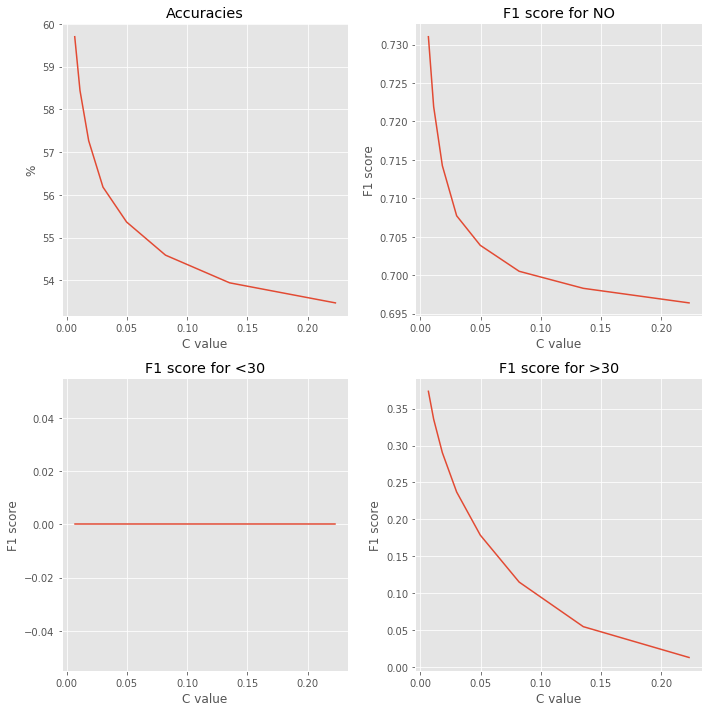

In [26]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,1)
ax.plot(c_checks, accuracies)
ax.set_xlabel('C value')
ax.set_ylabel('%')
ax.set_title('Accuracies')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(c_checks, f1_scores[:,0])
ax1.set_xlabel('C value')
ax1.set_ylabel('F1 score')
ax1.set_title('F1 score for NO')

ax2 = fig.add_subplot(2,2,3)
ax2.plot(c_checks, f1_scores[:,1])
ax2.set_xlabel('C value')
ax2.set_ylabel('F1 score')
ax2.set_title('F1 score for <30')

ax3 = fig.add_subplot(2,2,4)
ax3.plot(c_checks, f1_scores[:,2])
ax3.set_xlabel('C value')
ax3.set_ylabel('F1 score')
ax3.set_title('F1 score for >30')

plt.tight_layout()
plt.show()

From the above code, we can see that the maximum accuracy we achieved was around 60% using mean squared error as the objective function. This is worse than using binary entropy. This makes sense becaue binary entropy seems to be a common objective function. However, both methods have pros and cons. A decent review can be found [here](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/). We should also note that our highest accuracy (and f1 scores) came with small $C$ values, however using $C=0$ resulted in a singular matrix. Therefore we used small $C$ values here. Finally, the F1 score for patients returning to the hospital in less than 30 days is zero for allt $C$ value here. This is a result of our model not predicting any patients in this category.

<a id="thoughts"></a>
## Final Thoughts

- sci-kit learn has many useful built in models and rewriting them doesn't make much sense in many cases, with learning exercises being a notable exception.

- The $C$ parameter in [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is the inverse of the regularization strength. 

- The highest accuracy we achieved with linear regression classifiers was only around 60%. This is likely not high enough to be used in a medical situation. This means that we will still need to pursue other methods to increase our accuracy (or f1 scores) to acceptable levels for health care. 